In [432]:
import pandas as pd

In [433]:
import ToolBox as tb

In [434]:
# Cargar el conjunto de datos de entrenamiento
train_data = pd.read_csv('./Data/train.csv')

# Mostrar los primeros registros del conjunto de datos
train_data.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [435]:
train_data['Ram'] = train_data['Ram'].str.replace('GB', '').astype(int)

In [436]:
train_data['Weight'] = train_data['Weight'].str.replace('kg', '').astype(float)

In [437]:
train_data['Memory'] = train_data['Memory'].str.replace('1.0TB', '1000GB', regex=False)
train_data['Memory'] = train_data['Memory'].str.replace('2.0TB', '2000GB', regex=False)
train_data['Memory'] = train_data['Memory'].str.replace('1.000TB', '1000GB', regex=False)
train_data['Memory'] = train_data['Memory'].str.replace('TB', '000GB', regex=False)

In [438]:
def extraer_memoria(memory):
    ssd, hdd, flash, hybrid = 0, 0, 0, 0
    for x in memory.split('+'):
        x=x.strip()
        if 'SSD' in x:
            ssd = int(x.replace('SSD', '').replace('GB', '').strip())
        elif 'HDD' in x:
           hdd = int(x.replace('HDD', '').replace('GB', '').strip())
        elif 'Flash' in x:
            flash = int(x.replace('GB', '').replace('Flash Storage','').strip())
        elif 'Hybrid' in x:
            hybrid = int(x.replace('GB', '').replace('Hybrid','').strip())
            
            
    return pd.Series([ssd, hdd, flash, hybrid])
    

In [439]:
train_data[['SSD', 'HDD', 'Flash', 'Hybrid']] = train_data['Memory'].apply(extraer_memoria)

In [440]:
train_data['Gpu']=train_data['Gpu'].str.strip()

In [441]:
def extraer_gpu(gpu):
    if 'Radeon' in gpu or 'Firepro' in gpu:
        return 'Radeon' if 'Radeon' in gpu else 'Firepro'
    elif 'AMD' in gpu:
        return 'Radeon'
    elif 'UHD' in gpu or 'Iris' in gpu:
        return 'UHD' if 'UHD' in gpu else 'Iris'
    elif 'Intel' in gpu:
        return 'HD'
    elif 'Quadro' in gpu:
        return 'Quadro'
    elif 'Nvidia' in gpu:
        return 'GeForce'

train_data['Gpu_Type'] = train_data['Gpu'].apply(extraer_gpu)

print(train_data[['Gpu', 'Gpu_Type']].head())


                       Gpu Gpu_Type
0       AMD Radeon R7 M445   Radeon
1    Intel HD Graphics 505       HD
2    Intel HD Graphics 520       HD
3  Nvidia GeForce GTX 1070  GeForce
4    Intel HD Graphics 520       HD


In [442]:
import re

In [443]:
def extraer_cpu(cpu):
    tipo = None
    tipo2 = None
    if 'AMD' in cpu:
        tipo = 'AMD'
        T = cpu.split()[1]
        if 'A' in T:
            tipo2 = 'A-Series'
        elif 'FX' in T:
            tipo2 = 'FX'
        elif 'E' in T:
            tipo2 = 'E-Series'
        elif 'Ryzen' in T:
            tipo2 = 'Ryzen'
    elif 'Intel' in cpu:
        if 'Celeron' in cpu:
            tipo = 'Celeron'
            if 'Dual' in cpu:
                tipo2 = 'Dual'
            else:
                tipo2 = 'Quad'
        elif 'Pentium' in cpu:
            tipo = 'Pentium'
            if 'Dual' in cpu:
                tipo2 = 'Dual'
            else:
                tipo2 = 'Quad'
        elif 'Atom' in cpu:
            tipo = 'Atom'
            T = cpu.split()[2]
            if 'x' in T:
                tipo2 = 'X-Series'
            else:
                tipo2 = 'Z-Series'
        elif 'Xeon' in cpu:
            tipo = 'Xeon'
            tipo2='E-Series'
        else:
            tipo = cpu.split()[2]
            if tipo == 'M':
                tipo2 = 'M'
            else:
                tipo2 = re.search(r'\d+([A-Za-z])', cpu).group(1) if re.search(r'\d+([A-Za-z])', cpu) else 'Unknown'
    return pd.Series([tipo, tipo2])

In [444]:
train_data[['Cpu_Tipo', 'Cpu_Tipo2']]=train_data['Cpu'].apply(extraer_cpu)

In [445]:
def extraer_hz_cpu(cpu):
    patron = r'(\d+(\.\d+)?)GHz'
    return float(re.search(patron, cpu).group(1))

In [446]:
train_data['GHz'] = train_data['Cpu'].apply(extraer_hz_cpu)

In [447]:
def is_ips(screen_resolution):
    return True if 'IPS' in screen_resolution else False 

In [448]:
def is_touchscreen(screen_resolution):
    return True if 'Touchscreen' in screen_resolution else False  

In [449]:
train_data['Is_IPS'] = train_data['ScreenResolution'].apply(is_ips)

In [450]:
train_data['IS_TouchScreen'] = train_data['ScreenResolution'].apply(is_touchscreen)

In [451]:
def get_num_pixels(screen_resolution):
    # Buscar el patrón de resolución
    match = re.search(r'(\d+)x(\d+)', screen_resolution)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return width * height
    return None

In [452]:
train_data['num_pixels']  = train_data['ScreenResolution'].apply(get_num_pixels)

In [453]:
train_data[['ScreenResolution','Is_IPS','IS_TouchScreen','num_pixels']]

,ScreenResolution,Is_IPS,IS_TouchScreen,num_pixels
0,1366x768,False,False,1049088
1,1366x768,False,False,1049088
2,Full HD 1920x1080,False,False,2073600
3,IPS Panel 4K Ultra HD 3840x2160,True,False,8294400
4,Full HD / Touchscreen 1920x1080,False,True,2073600
...,...,...,...,...
907,IPS Panel Touchscreen 1366x768,True,True,1049088
908,Full HD 1920x1080,False,False,2073600
909,1366x768,False,False,1049088
910,Full HD 1920x1080,False,False,2073600


In [454]:
gpu_dummies = pd.get_dummies(train_data['Gpu_Type'], prefix='Gpu_Type')
train_data = pd.concat([train_data, gpu_dummies], axis=1)
train_data = train_data.drop(columns=['Gpu', 'Gpu_Type'])

In [455]:
cpu_tipo_dummies = pd.get_dummies(train_data['Cpu_Tipo'], prefix='Cpu_Tipo')
cpu_tipo2_dummies = pd.get_dummies(train_data['Cpu_Tipo2'], prefix='Cpu_Tipo2')
train_data = pd.concat([train_data, cpu_tipo_dummies, cpu_tipo2_dummies], axis=1)
train_data = train_data.drop(columns=['Cpu', 'Cpu_Tipo', 'Cpu_Tipo2'])

In [456]:
train_data['OpSys'] = train_data['OpSys'].str.replace('10 S', '10').astype(str)

In [457]:
OpSys_dummies = pd.get_dummies(train_data['OpSys'], prefix='OpSys')
train_data = pd.concat([train_data, OpSys_dummies], axis=1)
train_data = train_data.drop(columns=['OpSys'])

In [458]:
Company_dummies = pd.get_dummies(train_data['Company'], prefix='Company')
train_data = pd.concat([train_data, Company_dummies], axis=1)
train_data = train_data.drop(columns=['Company'])

In [459]:
TypeName_dummies = pd.get_dummies(train_data['TypeName'], prefix='TypeName')
train_data = pd.concat([train_data, TypeName_dummies], axis=1)
train_data = train_data.drop(columns=['TypeName'])

In [460]:
features = ['Inches','Ram', 'Weight', 'SSD', 'HDD', 'Flash', 'Hybrid', 'Is_IPS', 'num_pixels', 'IS_TouchScreen','GHz']
features += [col for col in train_data.columns if col.startswith('Gpu_Type_')]
features += [col for col in train_data.columns if col.startswith('Cpu_Tipo_')]
features += [col for col in train_data.columns if col.startswith('OpSys')]
features += [col for col in train_data.columns if col.startswith('Company')]
features += [col for col in train_data.columns if col.startswith('TypeName')]

In [461]:
import matplotlib.pyplot as plt

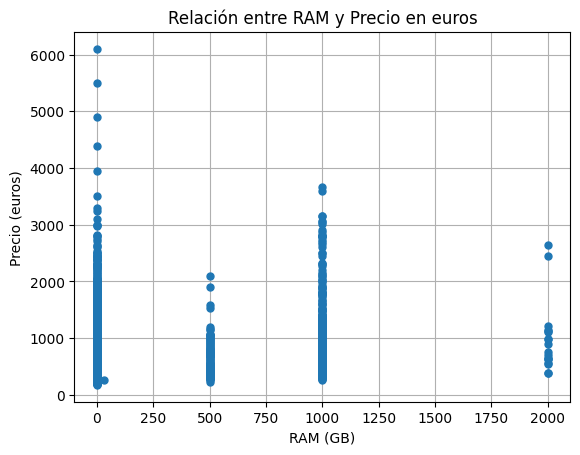

In [462]:
plt.plot(train_data['HDD'], train_data['Price_euros'], 'o', markersize=5)  # 'o' indica que se utilicen puntos para los puntos de datos
plt.title('Relación entre RAM y Precio en euros')
plt.xlabel('RAM (GB)')
plt.ylabel('Precio (euros)')
plt.grid(True)  # Añade una cuadrícula al gráfico
plt.show()

In [463]:
Ram_dummies = pd.get_dummies(train_data['Ram'], prefix='Ram')
train_data = pd.concat([train_data, Ram_dummies], axis=1)
train_data = train_data.drop(columns=['Ram'])

In [464]:
features += [col for col in train_data.columns if col.startswith('Ram')]

# Test

In [465]:
# Cargar el conjunto de datos de prueba
test_data = pd.read_csv('./Data/test.csv')

In [466]:
test_data.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,181,1098,HP,Spectre x360,Ultrabook,13.3,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.3kg
1,708,330,Acer,Aspire 5,Notebook,15.6,1366x768,AMD A12-Series 9720P 2.7GHz,8GB,256GB SSD,AMD Radeon RX 540,Windows 10,2.2kg
2,862,1260,Acer,Aspire ES1-572,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,500GB HDD,Intel HD Graphics 520,Linux,2.4kg
3,1064,1137,HP,EliteBook 1040,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.43kg
4,702,1015,HP,ENVY -,Notebook,13.3,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.34kg


In [467]:
test_data['Ram'] = test_data['Ram'].str.replace('GB', '').astype(int)    

In [468]:
test_data['Ram'].unique()

array([16,  8,  4, 64, 12,  6, 32,  2, 24])

In [469]:
test_data['Weight'] = test_data['Weight'].str.replace('kg', '').astype(float)

In [470]:
test_data['Memory'] = test_data['Memory'].str.replace('1.0TB', '1000GB', regex=False)
test_data['Memory'] = test_data['Memory'].str.replace('2.0TB', '2000GB', regex=False)
test_data['Memory'] = test_data['Memory'].str.replace('1.000TB', '1000GB', regex=False)
test_data['Memory'] = test_data['Memory'].str.replace('TB', '000GB', regex=False)

In [471]:
test_data[['SSD', 'HDD', 'Flash', 'Hybrid']] = test_data['Memory'].apply(extraer_memoria)
test_data['Gpu'] = test_data['Gpu'].str.strip()

In [472]:
test_data['Gpu_Type'] = test_data['Gpu'].apply(extraer_gpu)

In [473]:
test_data[['Cpu_Tipo', 'Cpu_Tipo2']] = test_data['Cpu'].apply(extraer_cpu)

In [474]:
test_data['GHz'] = test_data['Cpu'].apply(extraer_hz_cpu)

In [475]:
test_data['Is_IPS'] = test_data['ScreenResolution'].apply(is_ips)
test_data['IS_TouchScreen'] = test_data['ScreenResolution'].apply(is_touchscreen)

In [476]:
test_data['num_pixels'] = test_data['ScreenResolution'].apply(get_num_pixels)

gpu_dummies_test = pd.get_dummies(test_data['Gpu_Type'], prefix='Gpu_Type')
test_data = pd.concat([test_data, gpu_dummies_test], axis=1)
test_data = test_data.drop(columns=['Gpu', 'Gpu_Type'])

cpu_tipo_dummies_test = pd.get_dummies(test_data['Cpu_Tipo'], prefix='Cpu_Tipo')
cpu_tipo2_dummies_test = pd.get_dummies(test_data['Cpu_Tipo2'], prefix='Cpu_Tipo2')
test_data = pd.concat([test_data, cpu_tipo_dummies_test, cpu_tipo2_dummies_test], axis=1)
test_data = test_data.drop(columns=['Cpu', 'Cpu_Tipo', 'Cpu_Tipo2'])

test_data['OpSys'] = test_data['OpSys'].str.replace('10 S', '10').astype(str)

OpSys_dummies_test = pd.get_dummies(test_data['OpSys'], prefix='OpSys')
test_data = pd.concat([test_data, OpSys_dummies_test], axis=1)
test_data = test_data.drop(columns=['OpSys'])

Company_dummies_test = pd.get_dummies(test_data['Company'], prefix='Company')
test_data = pd.concat([test_data, Company_dummies_test], axis=1)
test_data = test_data.drop(columns=['Company'])

TypeName_dummies_test = pd.get_dummies(test_data['TypeName'], prefix='TypeName')
test_data = pd.concat([test_data, TypeName_dummies_test], axis=1)
test_data = test_data.drop(columns=['TypeName'])

In [477]:
features_test = ['Inches', 'Weight', 'SSD', 'HDD', 'Flash', 'Hybrid', 'Is_IPS', 'num_pixels', 'IS_TouchScreen','GHz']
features_test += [col for col in test_data.columns if col.startswith('Gpu_Type_')]
features_test += [col for col in test_data.columns if col.startswith('Cpu_Tipo_')]
features_test += [col for col in test_data.columns if col.startswith('OpSys')]
features_test += [col for col in test_data.columns if col.startswith('Company')]
features_test += [col for col in test_data.columns if col.startswith('TypeName')]

In [478]:
Ram_dummies = pd.get_dummies(test_data['Ram'], prefix='Ram')
test_data = pd.concat([test_data, Ram_dummies], axis=1)
test_data = test_data.drop(columns=['Ram'])

In [479]:
features_test += [col for col in test_data.columns if col.startswith('Ram')]

# Selección de modelo

In [480]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [481]:
features_train=features

In [482]:
features=[x for x in features_test if x in features_train]

In [483]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

In [484]:
# Características y objetivo
X = train_data[features]
y = train_data['Price_euros']

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características numéricas
scaler = StandardScaler()
num_features = ['Inches', 'Weight', 'SSD', 'HDD', 'Flash', 'Hybrid', 'num_pixels','GHz']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
test_data[num_features] = scaler.transform(test_data[num_features])

In [485]:
# Entrenar el modelo con Ridge
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred = model.predict(X_val)

# Evaluar el modelo utilizando MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 212.81946170192754


In [486]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo
rf = RandomForestRegressor(random_state=42)

# Definir los parámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el GridSearchCV
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=2)

# Entrenar el modelo
grid_search.fit(X_train, y_train)

# Mejor estimador
best_rf = grid_search.best_estimator_

# Predecir en el conjunto de validación
y_pred = best_rf.predict(X_val)

# Evaluar el modelo utilizando MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mean Absolute Error (MAE): 185.42611693628643
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [487]:
# Definir el modelo y los parámetros para GridSearchCV
lasso = Lasso()
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Crear y ajustar GridSearchCV
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, scoring=scoring, cv=5, n_jobs=-1, verbose=2)
grid_search_lasso.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred_lasso = grid_search_lasso.best_estimator_.predict(X_val)

# Evaluar el modelo utilizando MAE
mae_lasso = mean_absolute_error(y_val, y_pred_lasso)
print(f"Mean Absolute Error (MAE) para Lasso: {mae_lasso}")
print(f"Mejores parámetros para Lasso: {grid_search_lasso.best_params_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mean Absolute Error (MAE) para Lasso: 209.82374323452467
Mejores parámetros para Lasso: {'alpha': 1}


In [488]:
# Definir el modelo y los parámetros para GridSearchCV
xgbr = XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_xgbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Crear y ajustar GridSearchCV
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search_xgbr = GridSearchCV(estimator=xgbr, param_grid=param_grid_xgbr, scoring=scoring, cv=5, n_jobs=-1, verbose=2)
grid_search_xgbr.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred_xgbr = grid_search_xgbr.best_estimator_.predict(X_val)

# Evaluar el modelo utilizando MAE
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)
print(f"Mean Absolute Error (MAE) para XGBRegressor: {mae_xgbr}")
print(f"Mejores parámetros para XGBRegressor: {grid_search_xgbr.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mean Absolute Error (MAE) para XGBRegressor: 169.30673118382856
Mejores parámetros para XGBRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


In [489]:
from sklearn.ensemble import GradientBoostingRegressor

# Definir el modelo y los parámetros para GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Crear y ajustar GridSearchCV
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, scoring=scoring, cv=5, n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_pred_gbr = grid_search_gbr.best_estimator_.predict(X_val)

# Evaluar el modelo utilizando MAE
mae_gbr = mean_absolute_error(y_val, y_pred_gbr)
print(f"Mean Absolute Error (MAE) para GradientBoostingRegressor: {mae_gbr}")
print(f"Mejores parámetros para GradientBoostingRegressor: {grid_search_gbr.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mean Absolute Error (MAE) para GradientBoostingRegressor: 169.0274633664264
Mejores parámetros para GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300}


# Los mejores osn el de GradientBoosing y XGBRegressor

In [500]:
# Predecir los precios utilizando el modelo GradientBoostingRegressor entrenado
y_test_pred =  grid_search_gbr.best_estimator_.predict(test_data[features])

In [501]:
predictions = pd.DataFrame({
    'id': test_data.id,
    'Price_euros': y_test_pred
})


In [502]:
predictions

,id,Price_euros
0,181,1629.474343
1,708,477.893211
2,862,364.760021
3,1064,1427.223067
4,702,1134.841767
...,...,...
386,1281,902.649584
387,524,2590.503424
388,1015,481.700516
389,1236,382.378363


# Comprobacion

In [493]:
sample = pd.read_csv("Data/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [494]:
predictions.head()

,id,Price_euros
0,181,1641.308838
1,708,492.278625
2,862,362.825958
3,1064,1420.324097
4,702,1026.438599


In [495]:
predictions.shape

(391, 2)

In [496]:
import urllib
from PIL import Image

In [503]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                predictions.to_csv("submission3.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [498]:
predictions

,id,Price_euros
0,181,1641.308838
1,708,492.278625
2,862,362.825958
3,1064,1420.324097
4,702,1026.438599
...,...,...
386,1281,929.346191
387,524,2393.245361
388,1015,477.365753
389,1236,365.958710


In [504]:
chequeator(predictions) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
